# Phys 512: Homework 1

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RectBivariateSpline
import scipy
import time
import scipy.constants as cst

## Question 1: Roundoff error in long term integrations of planetary orbits

a)

In [75]:
GM_sun = 1.3271e20 # m^3 / s^2
r = 1.496e11 # m 
acc = - GM_sun / r**2
v_tan = np.sqrt(GM_sun / r)
orbital_period = 3600*24*365

In [76]:
# define function 'orbit' 

def orbit(N):
    '''
    Simulates the position of the earth's position using the semi-implicit Euler Method.
    
    Arguments:
    - N (int): Number of steps
    
    Returns:
    - arr_x (float): array of earths position in x for each time step
    - arr_y (float): array of earths position in y for each time step
    '''
   
    # define timestep
    dt = orbital_period / N
    
    # define initial positions and velocities in x and y:
    x = r
    y = 0
    v_x = 0
    v_y = v_tan
    
    # initialize arrays to track position
    arr_x = [x]
    arr_y = [y]
    
    # loop over time steps 
    for n in range(N):
       
        a_x = acc * (x / r)
        a_y = acc * (y / r)

        v_x += a_x * dt
        v_y += a_y * dt

        x += v_x * dt
        y += v_y * dt

        arr_x.append(x)
        arr_y.append(y)
        
    return arr_x, arr_y
    

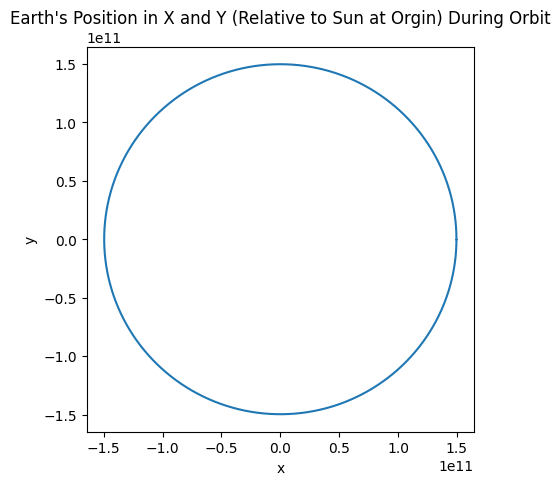

In [92]:
# call 'orbit' for 10000 steps
x, y = orbit(10000)

# plot the planet's orbit
F = plt.figure(figsize=(5,5))
plt.plot(x, y)
plt.xlabel('x')
plt.ylabel('y')
plt.title("Earth's Position in X and Y (Relative to Sun at Orgin) During Orbit")
plt.show()

b)

In [78]:
# define function 'E_total' that returns the total energy (relative to mass) given the position and velocity
def E_total(x, y, v_x, v_y):
    '''
    Calculates total energy the earths in orbit given its position and velocity
    
    Arguments:
    - x (float): the body's position in x relative to its star
    - y (float): the body's position in y relative to its star
    - v_x (float): the body's velocity in x
    - v_Y (float): the body's velocity in x
    
    Returns:
    - E (float): Total energy relative to mass 
    '''
    
    KE = (1 / 2) * (v_x**2 + v_y**2)
    PE = - GM_sun / np.sqrt(x**2 + y**2)
    return KE + PE

In [79]:
# define initial positions and velocities in x and y
x0 = r
y0 = 0.0
v_x0 = 0.0
v_y0 = v_tan

# calculate initial energy
E0 = E_total(x0, y0, v_x0, v_y0)

In [80]:
# define a function 'Delta_E' that returns the fractional change in energy for a given number of steps

def Delta_E(N):
    '''
    Calculates the fractional change in the earths energy after simulating one orbit
    
    Arguments:
    - N (int): number of steps
    
    Returns:
    - delta_E (float): fractional change in energy over orbit
    '''

    # define timestep
    dt = orbital_period / N
    
    # set position and velocity values to initial values
    x = x0
    y = y0
    v_x = v_x0
    v_y = v_y0
    
    # loop over time steps 
    for n in range(N):
        
        a_x = acc * (x / r)
        a_y = acc * (y / r)

        v_x += a_x * dt
        v_y += a_y * dt

        x += v_x * dt
        y += v_y * dt
        
    # calculate final energy (after iterating over planets orbit)
    Ef = E_total(x, y, v_x, v_y)

    return abs((E0 - Ef) / E0)

In [87]:
# define array of number of steps
N_values = np.logspace(1, 8, 8, dtype=int)
# define associated timestep value in years
dt_values = 1 / N_values

# iterate over N_values to find the fractional change in energy associated with each n value
dE_values = []
for n in N_values:
    dE_values.append(Delta_E(n))

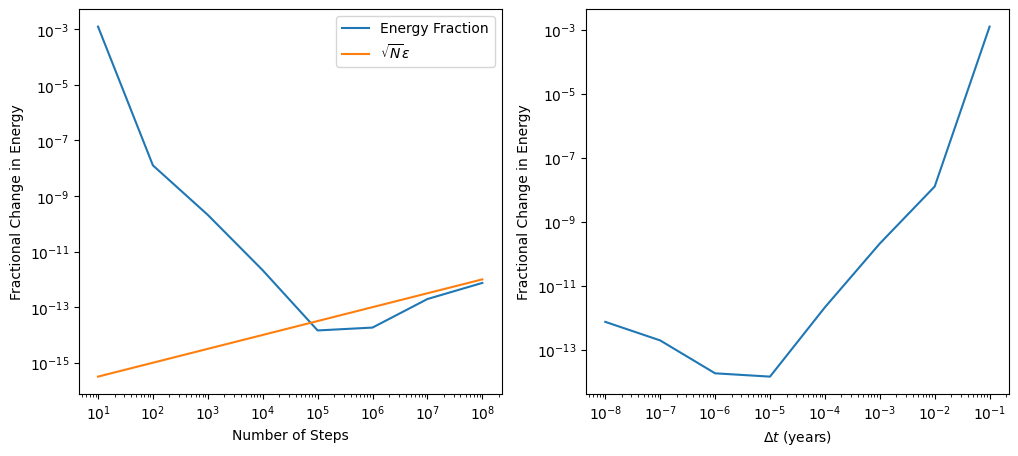

In [88]:
# plot the fractional change in energy as a function of the number of steps

F = plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(N_values, dE_values, label='Energy Fraction')
plt.plot(N_values, 1e-16*np.sqrt(N_values), label='$\sqrt{N} \epsilon$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of Steps')
plt.ylabel('Fractional Change in Energy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(dt_values, dE_values)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("$\Delta t$ (years)")
plt.ylabel('Fractional Change in Energy')
plt.show()

The fractional error is large when the number of steps is small. This is to be expected large $\Delta t$ values simulate a choppier and less acurate orbit. It decreases as the number of steps increases; however, once a threshold of approximately $10^5$ is surpassed, fractional error begins to increase with step size. This is because past this point, $\Delta t$ is sufficiently small that round off error will begin to dominate. Indeed past this point, the fractional change in energy scales close to $\sqrt{N} \epsilon$ as is expected from Brouwers Law.

## Question 2: Interpolation and thermodynamics

a)

In [40]:
# Define relevant constants
k_b = 1.38e-23 # J / K 
m_u = 1.66e-27 # kg
h_bar = 1.055e-34

# Define particle mass
m = 28 * m_u

In [89]:
# Define pressure and entropys functions
# Functions are formated to scale linearly with log(T) and log(rho)

def log_Pressure(log_T, log_rho):
    '''
    Calcualtes the base 10 logarithmic pressure
    
    Arguments:
    - log_T: base 10 logarithmic temperature
    - log_rho: base 10 logarithmic density
    
    Returns:
    - base 10 logarithmic pressure
    '''
    return np.log10(k_b / m) +  log_T + log_rho

def Scaled_Entropy(log_T, log_rho):
    '''
    Calcualtes the entropy scaled with boltzmann's constant
    
    Arguments:
    - log_T: base 10 logarithmic temperature
    - log_rho: base 10 logarithmic density
    
    Returns:
    - entropy divided by K_b
    '''
    return (5 / 2) + np.log(m * (m * k_b / (2 * np.pi * h_bar**2))**(3/2)) +(3/2)*np.log(10)*log_T - np.log(10)*log_rho 

In [59]:
# sample the function on a coarse grid and set up the interpolation
log_T = np.linspace(2, 3, 10)
log_rho = np.linspace(-6, 0, 10)

X, Y = np.meshgrid(log_T, log_rho, indexing='ij')

log_P = log_Pressure(X, Y)
S_scaled  = Scaled_Entropy(X, Y)

interp_Plog = RectBivariateSpline(log_T, log_rho, log_P)
interp_S = RectBivariateSpline(log_T, log_rho, S_scaled)

In [60]:
# sample function on fine grid
log_T = np.linspace(2, 3, 100) # K
log_rho = np.linspace(-6, 0, 100) # kg / m^3

X, Y = np.meshgrid(log_T, log_rho, indexing='ij')

# calculate interpolated values of log(P) and S/k_b
log_P = log_Pressure(X, Y)
S_scaled  = Scaled_Entropy(X, Y)

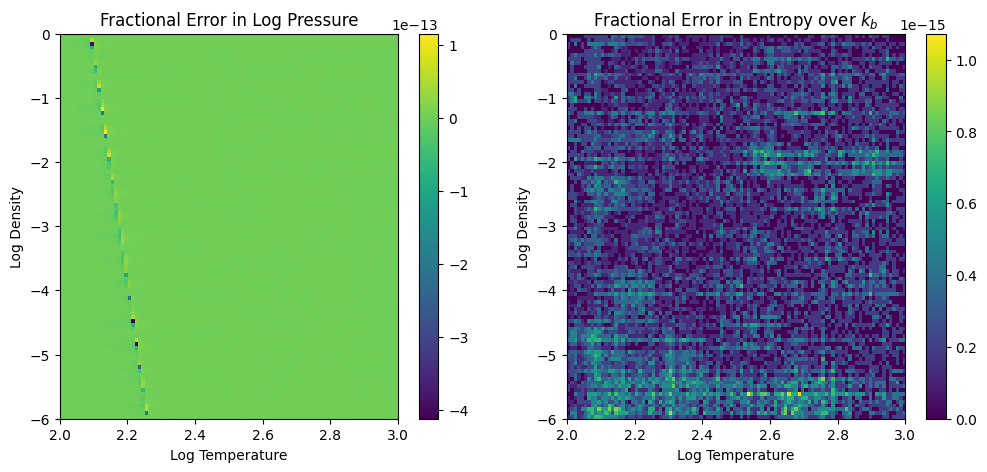

In [94]:
# plot the fractional error
error_P = abs(interp_Plog.ev(X, Y)-log_P)/log_P
error_S = abs(interp_S.ev(X, Y) - S_scaled)/S_scaled

F = plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title('Fractional Error in Log Pressure')
plt.imshow(error_P, origin='lower', extent=(2,3,-6,0), aspect='auto')
plt.xlabel("Log Temperature")
plt.ylabel("Log Density")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title('Fractional Error in Entropy over $k_b$')
plt.imshow(error_S, origin='lower', extent=(2,3,-6,0), aspect='auto')
plt.xlabel("Log Temperature")
plt.ylabel("Log Density")
plt.colorbar()

plt.show()

b)

In [95]:
# extract partial derivative from previous interpolation
dlogP_dlogT = interp_Plog.partial_derivative(dx=1, dy=0)
dS_dlogrho = interp_S.partial_derivative(dx=0, dy=1)

Some Math:

To retrieve $\frac{dP}{dT}$ from $\frac{dlogP}{dlogT}$


$\frac{d\log(P)}{d\log(T)} = \frac{dP}{dT} \frac{d\log(P)}{dP} \frac{dT}{d\log(T)}$


$\frac{dlogP}{dP} = \frac{1}{P\ln10}$


$\frac{dT}{dlogT} = T ln10$


$\therefore \frac{dP}{dT} = \frac{dlogP}{dlogT} \frac{T ln10}{P ln10}$


$\therefore \frac{dP}{dT} = \frac{dlogP}{dlogT} \frac{P}{T} = \frac{dlogP}{dlogT} k_b n$





To retrieve $\frac{dS}{dn}$ from $\frac{d(\frac{S}{k_b})}{dlog\rho}$


$\frac{dS}{dlog\rho} = k_b \frac{d(\frac{S}{k_b})}{dlog\rho}$


$\frac{dS}{d\rho} = \frac{dS}{dlog\rho} \frac{dlog\rho}{d\rho}$


$\frac{dlog\rho}{d\rho} = \frac{1}{\rho \ln10}$


$\frac{dS}{dn} = \frac{dS}{d\rho} m$


$\therefore \frac{dS}{dn} = \frac{k m}{\rho} \frac{d(\frac{S}{k_b})}{dlog\rho ln10} = \frac{k_b}{n ln10} \frac{d(\frac{S}{k_b})}{dlog\rho}$

In [98]:
# define number density array based on previous log density array 
n = np.power(10, log_rho) / m

# scale partial derivatives based on previous calculations
dPdT = dlogP_dlogT (log_T, log_rho) * (k_b * n)
dSdn = dS_dlogrho(log_T, log_rho) * (k_b / (n * np.log(10)))

In [101]:
# define the left hand side and right hand side of the equality
LHS = -dSdn
RHS = dPdT / n**2

# define absolute error
error = LHS - RHS

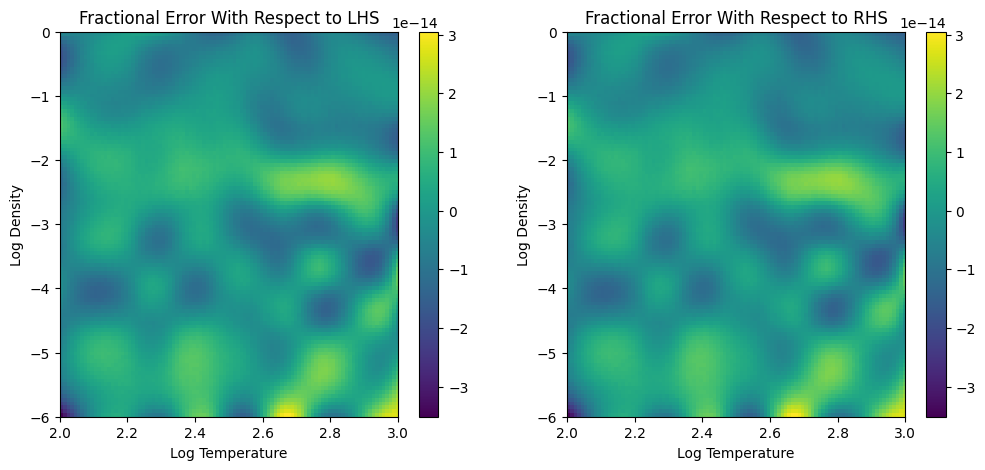

In [102]:
# plot the fractional error

F = plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title('Fractional Error With Respect to LHS')
plt.imshow(error/LHS, origin='lower', extent=(2,3,-6,0), aspect='auto')
plt.xlabel("Log Temperature")
plt.ylabel("Log Density")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title('Fractional Error With Respect to RHS')
plt.imshow(error/RHS, origin='lower', extent=(2,3,-6,0), aspect='auto')
plt.xlabel("Log Temperature")
plt.ylabel("Log Density")
plt.colorbar()
plt.show()

I find that the fractional error between the right and left hand sides of the equality is very small (on the order of $10^{-14}$. This indicates that the interpolator does an extremely good job solving for the partial derivative of the functions. This is unsurprising since both functions (log_Pressure and Scaled_Entropy) are linear with respect to their variables (log_T and log_rho). That indicates that in both case the partial derivative a constant and the interpolator solves it accurately. This result would not hold for more complicated equations of state. If the function cannot linearized than the interpolateor has to solve for unique parial derivatives at each Temperature/Density value decreasing its accuracy. 